## Module 2 : Finding Neutral Atom Qubit Gates
### Exercise 2-2 : Z-gate realization with single Atom Qubit

**Exercise Background:**
Z-gate (phase gate) adds a relative phase between $|0\rangle$ and $|1\rangle$ states:
$$Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}$$

**Implementation Method:**
- Apply detuning pulse $\delta_1(t)$ (window/square pulse)
- No population transfer: $\Omega_{01}=0$, $\Omega_r=0$, $\Delta_r=0$
- Phase accumulation: $\phi = \int_0^T \delta_1(t) dt$
- For Z-gate: need $\phi = \pi$

**Visualization Tasks:**
1. Plot Bloch sphere evolution for initial state $|+\rangle = \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$
2. Scan detuning amplitude $\delta_1$ and gate time $T$ to find optimal parameters
3. Measure fidelity with ideal Z-gate

Questions Unsolved : 
- How to get the steady state efficiently ?

In [1]:
%reset
%reload_ext autoreload
%autoreload 2

from common_imports import *
# Import ALL configuration variables from config file
from Default_SQCONFIG_for_Z_GATE import *

#### A single test
The goal is to plot the evolution of the state on the Bloch sphere under constant detuning for times $t = 0$ to $t = T = 20 \mu s$

**Expected Behavior:**
- Initial state $|+\rangle$ is on equator of Bloch sphere
- Detuning causes rotation around Z-axis (phase accumulation)
- State should remain on equator (no population change)
- After time $T$ with $\delta_1 \times T = \pi$, state should reach $|-\rangle$ (opposite side of equator)

In [2]:
# detuning pulse parameters
amp_delta_1 = 1.0 # detuning amplitude
T_detuning = 20 * time_unit # detuning pulse time T ( \mu s)

In [3]:
# initial state
psi0 = state_plus
tlist = scale_tlist * T_detuning
  
# update detuning pulse parameters ( atom0_ham_params should also be updated accordingly)
delta_1_pulse_args = {"T_detuning": T_detuning, "amp_delta_1": amp_delta_1}
atom0_ham_params["delta_1"] = (window_pulse, delta_1_pulse_args)

# construct Hamiltonian
H0, collapse_list = construct_TD_SAHam(atom0_ham_params, lindblad_params)

# simulate the dynamics
# simulate the dynamics
result = mesolve(H=H0, rho0=psi0, tlist=tlist, c_ops=collapse_list, e_ops=pauli_op_list, 
                 options={"store_final_state": 1, "store_states": 0})

#### Qubit Dynamics on the Bloch Sphere

Visualize the trajectory on Bloch sphere:
- **X, Y components**: Rotation in equatorial plane due to phase accumulation
- **Z component**: Should remain approximately constant (pure phase, no population transfer)
- **Trajectory**: Circular path around Z-axis if detuning is constant

In [4]:
exp_sx_circ, exp_sy_circ, exp_sz_circ = result.expect[:3]
exp_sx_circ, exp_sy_circ, exp_sz_circ = (
  np.array(exp_sx_circ),
  np.array(exp_sy_circ),
  np.array(exp_sz_circ),
)

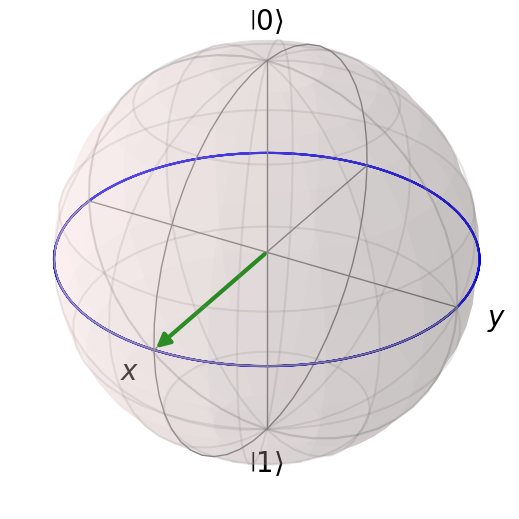

In [5]:
# initial state on Bloch Sphere
init_state = [1 / np.sqrt(2), 1 / np.sqrt(2)]
init_state = Qobj(init_state, dims=[[2],[1]])

# Create Bloch Sphere plot
sphere = Bloch()
sphere.add_points([exp_sx_circ, exp_sy_circ, exp_sz_circ], meth='l')
sphere.add_states(init_state)
sphere.show()

### Scan Parameters $|\delta_1|$ and $T_{\text{det}}$

**Parameter Scan Strategy:**
1. **Fixed amplitude, varying time**: For fixed $\delta_1$, scan different gate times $T$
2. **Fixed time, varying amplitude**: For fixed $T$, scan different detuning amplitudes

**Goal:**
- Find optimal combinations $(T, \delta_1)$ that maximize Z-gate fidelity
- Verify constraint: $\delta_1 \times T \approx \pi$ for optimal parameters
- Understand trade-off between gate speed and fidelity

In [10]:
# Import common utilities
from common_imports import *

# Import ALL configuration variables from config file
from Default_SQCONFIG_for_Z_GATE import *

# Import additional functions
from hamiltonian_builder import construct_TD_SAHam
from atom_basis import make_initial_list_for_gate_fidelity
from fidelity_calculator import (
    compute_state_fidelity, 
    compute_gate_fidelity_mixed,
)
from plotting_helpers import (
    plot_population_evolution,
    plot_multiple_population_evolution,
    plot_fidelity_vs_parameter,
    plt_config
)

In [11]:
amp_delta_1 = 1.0 # detuning amplitude (fixed)

# For scanning T_detuning (with fixed amp_delta_1)
T_detuning_list = np.array([0.5, 1, 2, 3, 5, 7.5, 10, 15, 20, 25]) * time_unit

# scaled time list ( in the unit of T_detuning )
scale_tlist = np.linspace(0, 1.5, 300)

In [12]:
# initial state
psi0 = state_plus

# store results
res_list = []
for T_detuning in T_detuning_list:
  tlist = scale_tlist * T_detuning
  
  # update detuning pulse parameters ( atom0_ham_params should also be updated accordingly)
  delta_1_pulse_args = {"T_detuning": T_detuning, "amp_delta_1": amp_delta_1}
  atom0_ham_params["delta_1"] = (window_pulse, delta_1_pulse_args)

  # construct Hamiltonian
  H0, collapse_list = construct_TD_SAHam(atom0_ham_params, lindblad_params)

  # simulate the dynamics
  result = mesolve(H0, psi0, tlist, collapse_list, expect_list, 
                   options={"store_final_state": 1, "store_states": 0})

  res_list.append(result)

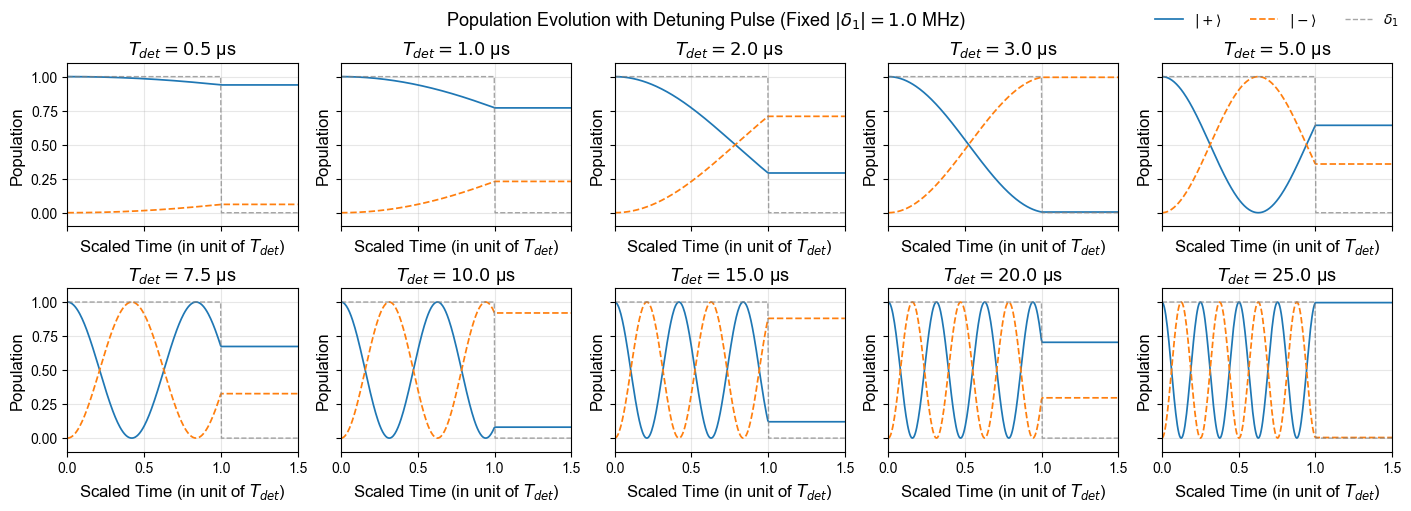

In [13]:
# the population dict
pop_dict_list = [
    {
        'result': res, 
        'indices': [0, 1], 
        'labels': [r'$|+\rangle$', r'$|-\rangle$'], 
        'sub_title': rf"$T_{{det}}={T_detuning:.1f}$ μs",
        'plot_pulse': True,
        'pulse_dict': {
            'detuning_pulse': {
                'data': window_pulse,
                'args': {'T_detuning': 1, 'amp_delta_1': amp_delta_1}, # because I use scaled time list
                'label': r'$\delta_1$',
                'style': 'Detuning_pulse'
            }
        },
        'xlabel': 'Scaled Time (in unit of $T_{det}$)',
        'ylabel': 'Population'
    }
    for res, T_detuning in zip(res_list, T_detuning_list)
]

# global pulse dict
# no global pulse to plot for detuning scan, I use pulse for each subplot instead


# plotting multiple population evolutions
plt.rcParams.update(plt_config)

fig, axes = plt.subplots(2, 5, figsize=(14, 5), sharex=True, sharey=True, constrained_layout=True)
axes = axes.ravel()

fig = plot_multiple_population_evolution(
    fig,
    axes,
    scale_tlist,
    pop_dict_list,
    suptitle = r"Population Evolution with Detuning Pulse (Fixed $|\delta_1|=1.0$ MHz)",
    global_plot_pulse=False,
    global_pulse_dict={}
)

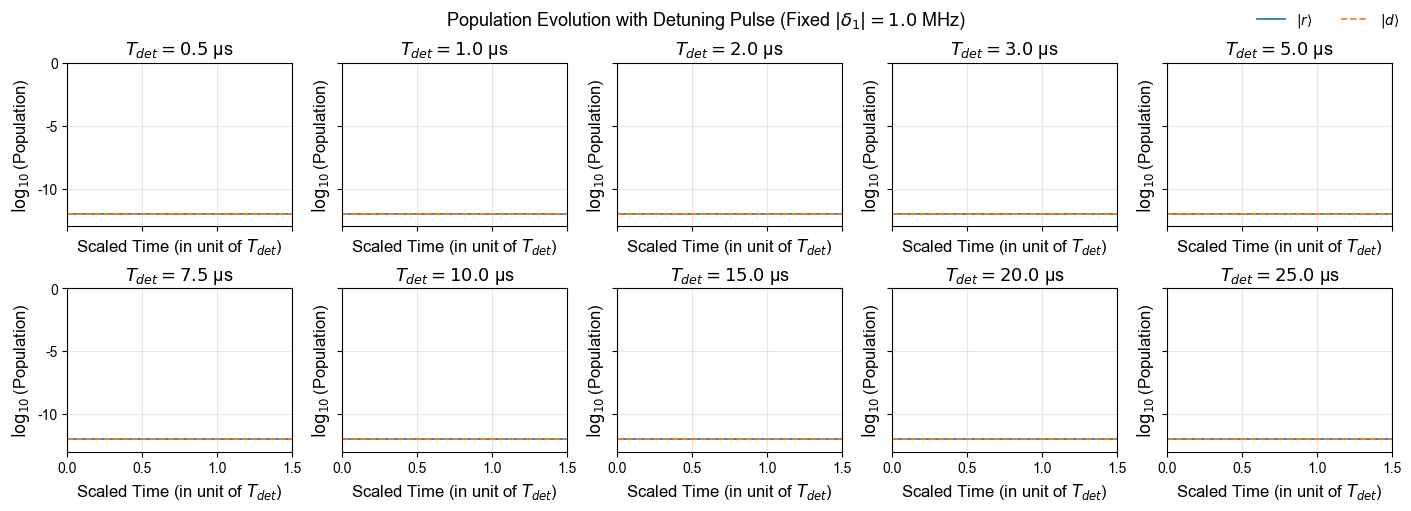

In [16]:
# the population dict
pop_dict_list = [
    {
        'result': res, 
        'indices': [2, 3], 
        'labels': [r'$|r\rangle$', r'$|d\rangle$'], 
        'sub_title': rf"$T_{{det}}={T_detuning:.1f}$ μs",
        'plot_pulse': False,
        'pulse_dict': {},
        'xlabel': 'Scaled Time (in unit of $T_{det}$)',
        'ylabel': 'Population',
        'log_scale': True,
        'ylim': (-13, 0)
    }
    for res, T_detuning in zip(res_list, T_detuning_list)
]

# global pulse dict
# no global pulse to plot for detuning scan, I use pulse for each subplot instead


# plotting multiple population evolutions
plt.rcParams.update(plt_config)

fig, axes = plt.subplots(2, 5, figsize=(14, 5), sharex=True, sharey=True, constrained_layout=True)
axes = axes.ravel()

fig = plot_multiple_population_evolution(
    fig,
    axes,
    scale_tlist,
    pop_dict_list,
    suptitle = r"Population Evolution with Detuning Pulse (Fixed $|\delta_1|=1.0$ MHz)",
    global_plot_pulse=False,
    global_pulse_dict={}
)

#### Observations for Fixed $|\delta_1| = 1.0$ MHz with Varying $T_{\text{det}}$

**Population Dynamics:**
1. **Pure phase evolution**: The populations oscillate between $|+\rangle$ and $|-\rangle$ states as expected for Z-gate rotation on Bloch sphere. For an ideal Z gate, we should expect $|+\rangle\rightarrow |-\rangle$ or vice versa, just as the $T_{\text{det}} = 3 $  μs case shows.
2. **No net population transfer**: Unlike X-gate (which transfers population), Z-gate only accumulates phase, causing rotation around Z-axis in Bloch sphere representation
3. **Optimal gate time**: Maximum fidelity occurs when $\delta_1 \times T_{\text{det}} = \pi$, corresponding to complete Z-gate operation

**Leakage to Auxiliary States:**
1. **Negligible leakage**: As shown in the log-scale plot, populations in $|r\rangle$ and $|d\rangle$ remain extremely small ($< 10^{-12}$)
2. **No direct coupling**: Since $\Omega_{01} = 0$, $\Omega_r = 0$, and $\Delta_r = 0$, there is no mechanism to populate Rydberg or auxiliary states
3. **Validation**: This confirms that detuning alone implements a pure phase gate without unwanted excitations

**Physical Insight:**
- Detuning $\delta_1(t)$ acts only on $|1\rangle$ state, creating energy difference between $|0\rangle$ and $|1\rangle$
- This energy difference leads to phase accumulation: $\phi = \int_0^T \delta_1(t) dt$
- The system remains in computational subspace $\{|0\rangle, |1\rangle\}$ throughout evolution
- Z-gate fidelity is determined by precise control of $\delta_1 \times T$ to achieve $\phi = \pi$

In [17]:
# For scanning amp_delta_1 (with fixed T_detuning)
amp_delta_1_list = np.linspace(0, 5.5, 12).tolist()

# detuning time (fixed)
T_detuning = 3 * time_unit

# scaled time list ( in the unit of T_detuning )
scale_tlist = np.linspace(0, 1.5, 300)
tlist = scale_tlist * T_detuning

In [18]:
# initial state
psi0 = state_plus

# store results
res_list = []
for amp_delta_1 in amp_delta_1_list:
  
  # update detuning pulse parameters ( atom0_ham_params should also be updated accordingly)
  delta_1_pulse_args = {"T_detuning": T_detuning, "amp_delta_1": amp_delta_1}
  atom0_ham_params["delta_1"] = (window_pulse, delta_1_pulse_args)

  # construct Hamiltonian
  H0, collapse_list = construct_TD_SAHam(atom0_ham_params, lindblad_params)

  # simulate the dynamics
  result = mesolve(H0, psi0, tlist, collapse_list, expect_list, 
                   options={"store_final_state": 1, "store_states": 0})

  res_list.append(result)

d:\anaconda3\envs\my_qiskit\Lib\site-packages\qutip\solver\solver_base.py:583: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


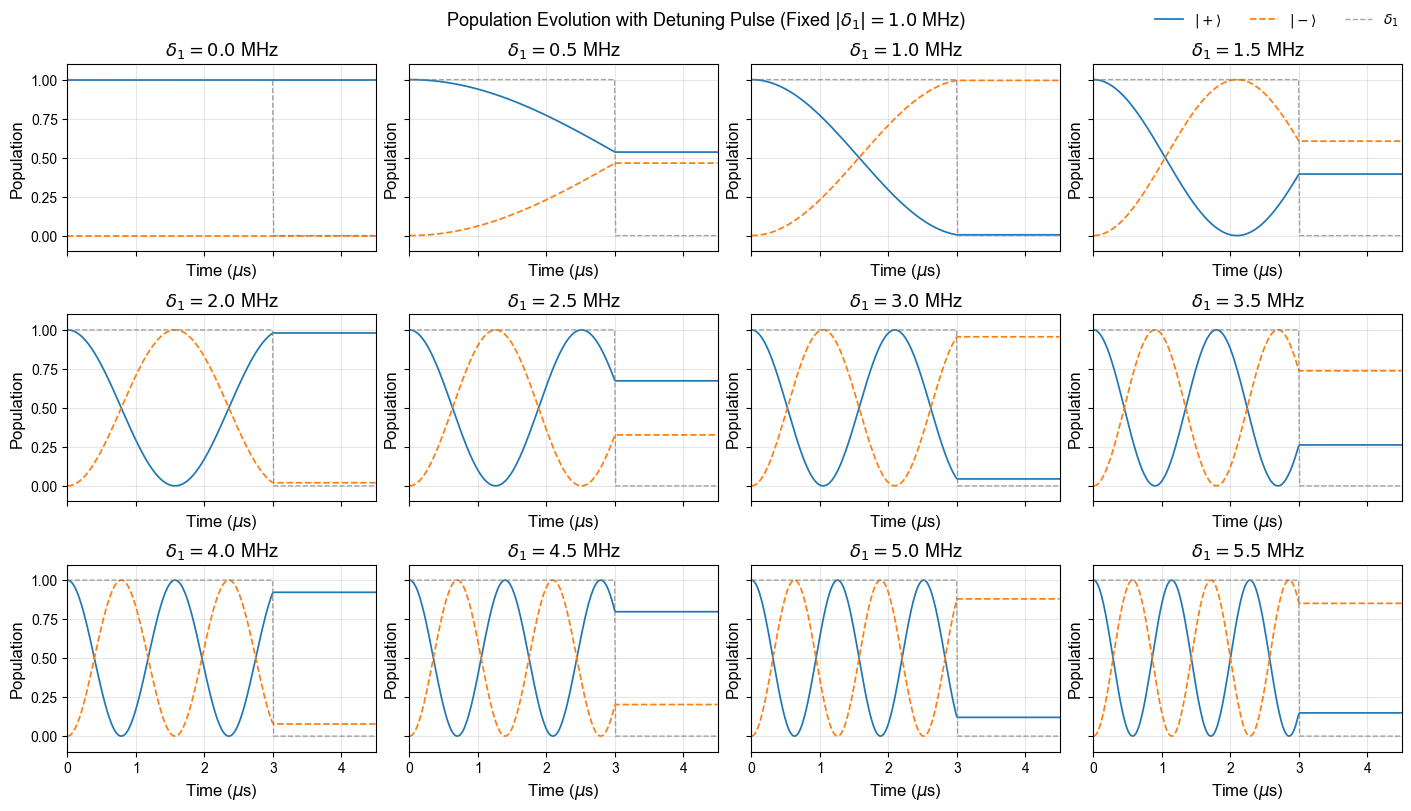

In [19]:
# the population dict
pop_dict_list = [
    {
        'result': res, 
        'indices': [0, 1], 
        'labels': [r'$|+\rangle$', r'$|-\rangle$'], 
        'sub_title': rf"$\delta_1={amp_delta_1:.1f}$ MHz",
        'plot_pulse': True,
        'pulse_dict': {
            'detuning_pulse': {
                'data': window_pulse,
                'args': {'T_detuning': T_detuning, 'amp_delta_1': 1}, # the amplitude is scaled
                'label': r'$\delta_1$',
                'style': 'Detuning_pulse'
            }
        }
    }
    for res, amp_delta_1 in zip(res_list, amp_delta_1_list)
]

# global pulse dict
# no global pulse to plot for detuning scan, I use pulse for each subplot instead


# plotting multiple population evolutions
plt.rcParams.update(plt_config)

fig, axes = plt.subplots(3, 4, figsize=(14, 8), sharex=True, sharey=True, constrained_layout=True)
axes = axes.ravel()

fig = plot_multiple_population_evolution(
    fig,
    axes,
    tlist,
    pop_dict_list,
    suptitle = r"Population Evolution with Detuning Pulse (Fixed $|\delta_1|=1.0$ MHz)",
    global_plot_pulse=False,
    global_pulse_dict={}
)

#### Fidelity Calculations

In [20]:
# store fidelity results
fidelity_arith_list = []
fidelity_geom_list = []
fidelity_mixed_list = []

delta_1_pulse_args["T_detuning"] = 3 * time_unit
for amp_delta_1 in amp_delta_1_list:
  delta_1_pulse_args["amp_delta_1"] = amp_delta_1
  atom0_ham_params['delta_1'] = (window_pulse, delta_1_pulse_args)

  # construct Hamiltonian
  H0, collapse_list = construct_TD_SAHam(atom0_ham_params, lindblad_params)
  
  # compute the state fidelities
  state_fidelity_list, _ = compute_state_fidelity(
    qs0_list,
    target_gate, 
    H0, 
    collapse_list, 
    tlist,
    psi0_list=psi0_list,
    comp_indices=comp_indices,
    expect_list=None
  )

  # compute different types of gate fidelities
  fidelity_mixed, fidelity_geom, fidelity_arith = compute_gate_fidelity_mixed(
    state_fidelity_list, dim_qubits, True
  )
  fidelity_mixed_list.append(fidelity_mixed)
  fidelity_geom_list.append(fidelity_geom)
  fidelity_arith_list.append(fidelity_arith)

d:\anaconda3\envs\my_qiskit\Lib\site-packages\qutip\core\data\expm.py:139: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  return Dense(scipy.linalg.sqrtm(matrix.as_ndarray()))


#### Plot fidelity vs parameters

<Axes: title={'center': 'Z Gate Infidelity vs $\\delta_1$ with fixed detuning Time = 3 $\\mu$s'}, xlabel='$\\delta_1$ (MHz)', ylabel='Infidelity'>

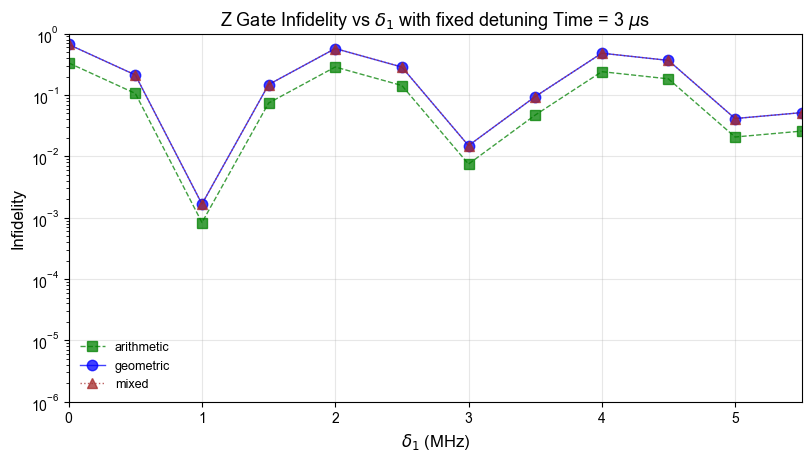

In [21]:
legend_list = ['arithmetic', 'geometric', 'mixed']

# plot
plt.rcParams.update(plt_config)

fig, ax = plt.subplots(figsize=(8, 4.5), sharex=True, sharey=True, constrained_layout=True)

plot_fidelity_vs_parameter(
    ax = ax,
    param_list = amp_delta_1_list,
    fidelity_list = [fidelity_arith_list, fidelity_geom_list, fidelity_mixed_list],
    legend_list = legend_list,
    title = rf"Z Gate Infidelity vs $\delta_1$ with fixed detuning Time = {T_detuning} $\mu$s",
    xlabel = r"$\delta_1$ (MHz)",
    ylabel = "Infidelity",
    use_infidelity = True,
    log_scale = True,
    xlim = None,
    ylim = (1e-6, 1),
    grid_alpha = 0.3,
    show_legend = True,
    plotting_style_list = [plotting_styles['fidelity_style_a'], 
                           plotting_styles['fidelity_style_b'], 
                           plotting_styles['fidelity_style_c']]
)